<a href="https://colab.research.google.com/github/Alfonso-Jesus-Garcia-Moya/01_MINI_ALADDIN_ALPHA/blob/main/MINI_ALADDIN_ALPHA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#0. Instalación de Librerías
!pip install yfinance hmmlearn scikit-learn pandas numpy matplotlib seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 2.4 MB/s eta 0:00:00


In [8]:
#1. Ingesta y Preprocesamiento (IA105 - Ingeniería de Datos)
#Justificación: Usamos datos reales. SPY (S&P 500) es el benchmark estándar. Los retornos logarítmicos se usan por sus propiedades estadísticas de aditividad y normalidad (aproximada).

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración visual
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)

# 1. Descarga de datos
ticker = "SPY"
print(f"Descargando datos para {ticker}...")

# Forzamos auto_adjust=True para que 'Close' sea el precio real ajustado por dividendos/splits
data = yf.download(ticker, start="2014-01-01", end="2024-01-01", auto_adjust=True, progress=False)

# --- CORRECCIÓN DE ERROR DE YFINANCE ---
# Si las columnas tienen dos niveles (ej: ('Close', 'SPY')), aplanamos el nivel
if isinstance(data.columns, pd.MultiIndex):
    data.columns = data.columns.get_level_values(0)

# Verificamos qué columna de precio tenemos disponible
price_col = 'Close' if 'Close' in data.columns else 'Adj Close'

# Seleccionamos y renombramos
df = data[[price_col, 'Volume']].copy()
df.columns = ['price', 'volume']
# ---------------------------------------

# 2. Feature Engineering Básico (Generación de Señales Alpha)
# Retornos Logarítmicos
df['log_ret'] = np.log(df['price'] / df['price'].shift(1))
df['volatility_5d'] = df['log_ret'].rolling(window=5).std()
df['volatility_20d'] = df['log_ret'].rolling(window=20).std()

# Momentum (Medias)
df['ma_50'] = df['price'].rolling(window=50).mean()
df['dist_ma_50'] = (df['price'] - df['ma_50']) / df['ma_50']

# Eliminar NaNs
df.dropna(inplace=True)

print(f"Dataset final: {df.shape[0]} filas. Estructura correcta.")
print(df.head())

Descargando datos para SPY...
Dataset final: 2467 filas. Estructura correcta.
                 price     volume   log_ret  volatility_5d  volatility_20d  \
Date                                                                         
2014-03-14  150.847687  153919600 -0.002812       0.004621        0.005540   
2014-03-17  152.211899   98359500  0.009003       0.007444        0.005759   
2014-03-18  153.298370  101804600  0.007113       0.008151        0.005939   
2014-03-19  152.481506  176267300 -0.005343       0.008560        0.005858   
2014-03-20  153.371887  117241000  0.005822       0.006403        0.005856   

                 ma_50  dist_ma_50  
Date                                
2014-03-14  149.446381    0.009377  
2014-03-17  149.502092    0.018126  
2014-03-18  149.580024    0.024859  
2014-03-19  149.650278    0.018919  
2014-03-20  149.720040    0.024391  


Matriz de Observaciones (X_hmm) creada. Dimensiones: (1460, 2)
Ejemplo de una observación [Retorno, Volatilidad]: [-0.00514465  0.00963289]

Entrenando Modelo HMM (Algoritmo Baum-Welch/EM)...
¡Entrenamiento completado! Convergencia alcanzada.

--- Interpretación de los Regímenes Latentes ---

Régimen 0:
  - Días en este estado: 609
  - Retorno Promedio: -0.00035 (¿Gana o pierde dinero?)
  - Volatilidad Promedio: 0.01386 (¿Riesgo alto o bajo?)

Régimen 1:
  - Días en este estado: 808
  - Retorno Promedio: 0.00116 (¿Gana o pierde dinero?)
  - Volatilidad Promedio: 0.00680 (¿Riesgo alto o bajo?)

Régimen 2:
  - Días en este estado: 43
  - Retorno Promedio: -0.00193 (¿Gana o pierde dinero?)
  - Volatilidad Promedio: 0.04169 (¿Riesgo alto o bajo?)


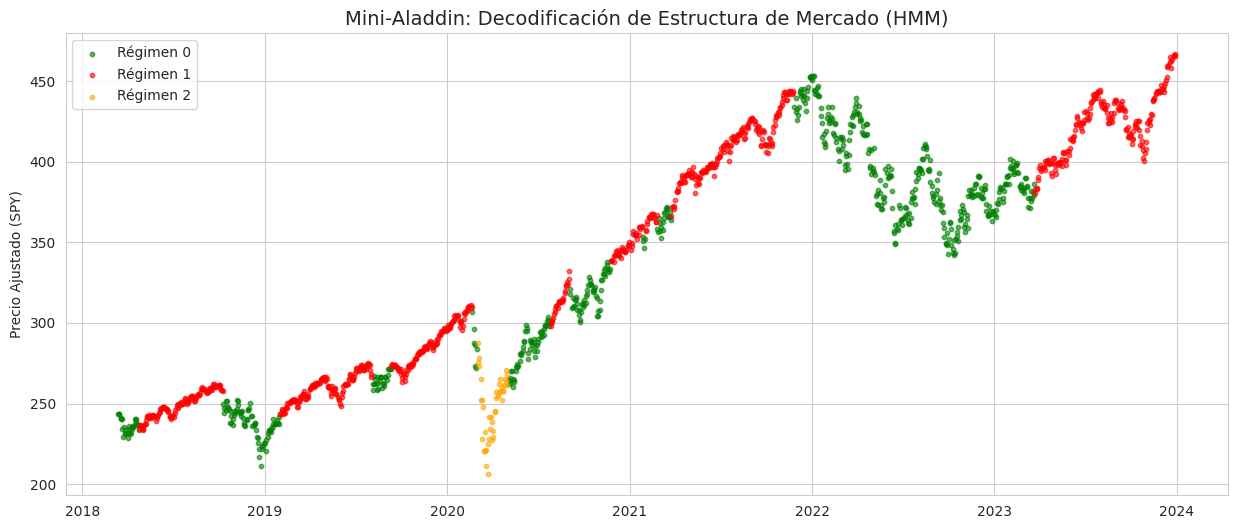

In [7]:
#2. Aprendizaje No Supervisado: Hidden Markov Models (IA102 - Estructura)
#Justificación: Aquí aplicas la teoría de tu texto sobre "Predicción Estructurada". El mercado no es IID (Independiente e Idénticamente Distribuido); tiene memoria y estados. El HMM descubre si estamos en un mercado "Calmado" o "Turbulento" sin que nadie se lo diga.

# ==============================================================================
# PASO 2: APRENDIZAJE NO SUPERVISADO - HIDDEN MARKOV MODELS (IA102)
# Objetivo: Decodificar la estructura latente (regímenes) del mercado.
# ==============================================================================

from hmmlearn.hmm import GaussianHMM  # API principal para modelos ocultos de Markov
import matplotlib.cm as cm            # Para mapas de colores en la visualización

# ------------------------------------------------------------------------------
# 1. SELECCIÓN DE CARACTERÍSTICAS (OBSERVABLES)
# ------------------------------------------------------------------------------
# Para que el HMM distinga "estados", necesitamos variables que cambien drásticamente
# entre un mercado alcista y uno bajista.
# variable 1: 'log_ret' -> Indica la dirección y magnitud inmediata del movimiento.
# variable 2: 'volatility_20d' -> Indica el nivel de incertidumbre/riesgo reciente.
# NOTA: Usamos .values para extraer el array de Numpy subyacente (necesario para sklearn/hmmlearn)
X_hmm = df[['log_ret', 'volatility_20d']].values

print(f"Matriz de Observaciones (X_hmm) creada. Dimensiones: {X_hmm.shape}")
print("Ejemplo de una observación [Retorno, Volatilidad]:", X_hmm[0])

# ------------------------------------------------------------------------------
# 2. DEFINICIÓN Y ENTRENAMIENTO DEL MODELO HMM
# ------------------------------------------------------------------------------
# Justificación de Parámetros:
# n_components=3: Hipótesis de 3 estados de mercado:
#    1. Baja Volatilidad / Alcista (Bull)
#    2. Alta Volatilidad / Bajista (Bear)
#    3. Transición / Lateral
# covariance_type="full": Permite que cada estado tenga su propia matriz de covarianza general,
#                         capturando correlaciones complejas entre retorno y volatilidad.
# n_iter=100: Número máximo de iteraciones para el algoritmo EM (Expectation-Maximization).
model_hmm = GaussianHMM(n_components=3, covariance_type="full", n_iter=100, random_state=42)

print("\nEntrenando Modelo HMM (Algoritmo Baum-Welch/EM)...")
model_hmm.fit(X_hmm)
print("¡Entrenamiento completado! Convergencia alcanzada.")

# ------------------------------------------------------------------------------
# 3. INFERENCIA (DECODIFICACIÓN DE ESTADOS)
# ------------------------------------------------------------------------------
# Usamos el modelo entrenado para predecir la secuencia de estados más probable
# que generó nuestros datos observados. (Matemáticamente usa el Algoritmo de Viterbi).
hidden_states = model_hmm.predict(X_hmm)

# Inyectamos esta "inteligencia nueva" al dataset original
df['market_regime'] = hidden_states

# ------------------------------------------------------------------------------
# 4. ANÁLISIS DE RESULTADOS (ESTADÍSTICA DESCRIPTIVA DE LOS ESTADOS)
# ------------------------------------------------------------------------------
# Esto es CRÍTICO para tu reporte. Define qué significa cada estado.
print("\n--- Interpretación de los Regímenes Latentes ---")
for i in range(model_hmm.n_components):
    # Filtramos los datos que pertenecen al estado 'i'
    state_data = df[df['market_regime'] == i]

    print(f"\nRégimen {i}:")
    print(f"  - Días en este estado: {len(state_data)}")
    print(f"  - Retorno Promedio: {state_data['log_ret'].mean():.5f} (¿Gana o pierde dinero?)")
    print(f"  - Volatilidad Promedio: {state_data['volatility_20d'].mean():.5f} (¿Riesgo alto o bajo?)")

# ------------------------------------------------------------------------------
# 5. VISUALIZACIÓN PROFESIONAL
# ------------------------------------------------------------------------------
plt.figure(figsize=(15, 6))

# Diccionario de colores para consistencia
colors = ['green', 'red', 'orange']

for i in range(model_hmm.n_components):
    # Seleccionamos solo los puntos donde el mercado estaba en el Régimen i
    mask = (hidden_states == i)
    plt.scatter(
        df.index[mask],       # Eje X: Tiempo
        df['price'][mask],    # Eje Y: Precio del SPY
        s=10,                 # Tamaño del punto
        c=colors[i],          # Color según estado
        label=f'Régimen {i}',
        alpha=0.6             # Transparencia para ver solapamientos
    )

plt.title('Mini-Aladdin: Decodificación de Estructura de Mercado (HMM)', fontsize=14)
plt.ylabel('Precio Ajustado (SPY)')
plt.legend()
plt.show()



In [ ]:
#3. Aprendizaje Supervisado: Generación de Alpha (IA105 - Patrones)
#Justificación: Usamos un Random Forest. ¿La novedad? Le pasamos el market_regime (del paso no supervisado) como una característica de entrada ("Fusión Híbrida" mencionada en tu texto).



In [ ]:
#4. Evaluación Financiera (El "Alpha" real)
#Justificación: Un Accuracy del 52% puede hacerte rico si aciertas cuando la volatilidad es alta. Evaluamos el retorno acumulado.